In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib as mlp 
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#import os


In [2]:
data = pd.read_csv('BlackFriday.csv')

In [3]:
data.head(10)

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969
5,1000003,P00193542,M,26-35,15,A,3,0,1,2.0,NaN,15227
6,1000004,P00184942,M,46-50,7,B,2,1,1,8.0,17.0,19215
7,1000004,P00346142,M,46-50,7,B,2,1,1,15.0,NaN,15854
8,1000004,P0097242,M,46-50,7,B,2,1,1,16.0,NaN,15686
9,1000005,P00274942,M,26-35,20,A,1,1,8,NaN,NaN,7871


In [4]:
data.shape

(537577, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 12 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null object
Age                           537577 non-null object
Occupation                    537577 non-null int64
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null int64
Product_Category_1            537577 non-null int64
Product_Category_2            370591 non-null float64
Product_Category_3            164278 non-null float64
Purchase                      537577 non-null int64
dtypes: float64(2), int64(5), object(5)
memory usage: 49.2+ MB


In [6]:
# I see that there are nulls in the data set 
# I want to see which columns has the null values -- Product Category 2 and 3 
data.isna().any()

User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool

In [7]:
data.isnull().sum()  # note that there are 537577 rows 

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64

It makes sense for there to be missing values because some customers might only buy one category of product and not buy from the other 2 product categories. We should fill the missing value with a 0 to show this. 

Perhaps also state here the objective of this project

Include the different sections:
        + EDA 
        + ML 
        + Conclusion & Recommendation 

Most features are categorical. We will fill in the NAs with 0's for Product Category 2 and 3 

In [8]:
data["Product_Category_2"] = data["Product_Category_2"].fillna(0)
data["Product_Category_3"] = data["Product_Category_3"].fillna(0)

# EDA

I want to know the number of unique values in the columns to check if there are recurring customers and to see the variety in products offered 

In [9]:
for col in data.columns:
    print(col, data[col].nunique())

User_ID 5891
Product_ID 3623
Gender 2
Age 7
Occupation 21
City_Category 3
Stay_In_Current_City_Years 5
Marital_Status 2
Product_Category_1 18
Product_Category_2 18
Product_Category_3 16
Purchase 17959


Some interesting findings: 
- repeating customers
- we can use these features to find interesting patterns in shopping habits

Goals:
- Predict purchase amount based on all features 
- Give recommendations based on age, location  

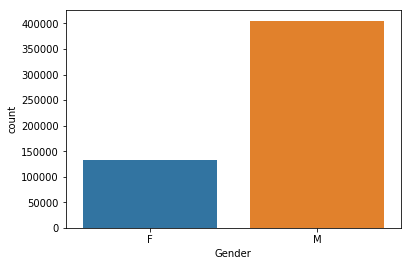

In [10]:
# Let's see ratio of women to men 
sns.countplot(data['Gender'])

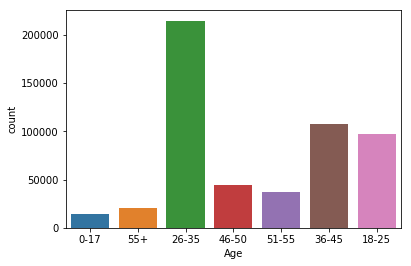

In [11]:
# Now for age 
sns.countplot(data['Age'])

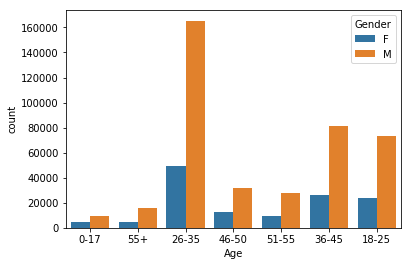

In [12]:
sns.countplot(data['Age'], hue = data['Gender'])

Text(0,0.5,'Count')

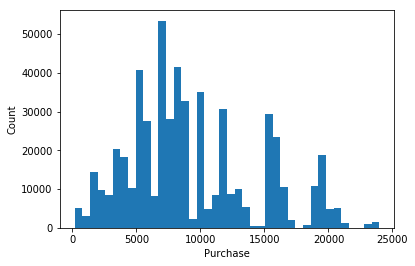

In [13]:
plt.hist(data['Purchase'], bins = 40)
plt.xlabel('Purchase')
plt.ylabel('Count')

If we predict purchase amount, this would be our y variable. It seems like it is right skewed but more or less normal. 

See how I can group by user and see total purchase. Then see division between gender. If strong, then this would be good predictor 

Check to see if there is variation in occupation across cities 

In [14]:
city_categs = ['A', 'B', 'C']

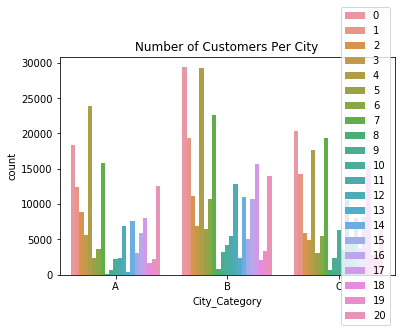

In [15]:
sns.countplot(data['City_Category'], order = city_categs, hue = data['Occupation'])
plt.title('Number of Customers Per City')
plt.legend(loc = 'right')

In [ ]:
# To see total purchases use group by 
tot_purchases_city = data.groupby(['City_Category', 'Occupation']).agg({'Purchase':np.mean})
sns.barplot(tot_purchases_city['City_Category', 'Purchase'], hue = tot_purchases_city)

Next, we'd like to see if there are strong correlations between any of the categories in the data set, so we can make a heat map of all the categories.

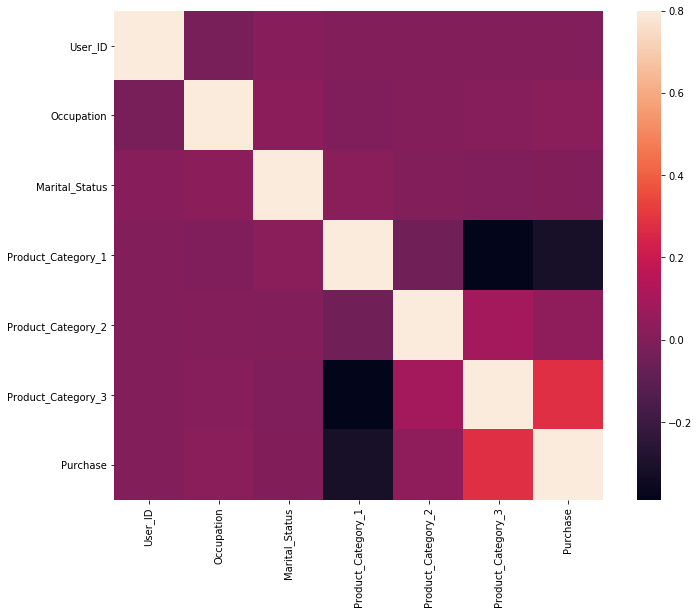

In [16]:
corrmat = data.corr()
fig,ax = plt.subplots(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)

This heat map shows that there is a positive correlation between marital status and age, which makes sense because older people are more likely to be married. It also shows that Product_1_Category has a negative correlation with Purchase, and Product_3_Category has a positive correlation with Purchase. Also, Product_1_Category has a negative correlation with Product_3_Category. We can also see a slight positive correlation between gender and occupation.

# Data Modeling

Since most of the columns of the data set contain categorical data, we want to map them to float values.

In [17]:
def map_gender(gender):
    if gender == 'M':
        return 1.0
    else:
        return 0
data['Gender'] = data['Gender'].apply(map_gender)


In [18]:
def map_age(age):
    if age == '0-17':
        return 0
    elif age == '18-25':
        return 1.0
    elif age == '26-35':
        return 2
    elif age == '36-45':
        return 3
    elif age == '46-50':
        return 4
    elif age == '51-55':
        return 5
    else:
        return 6
data['Age'] = data['Age'].apply(map_age)

In [19]:
def map_city_categories(city_category):
    if city_category == 'A':
        return 2.0
    elif city_category == 'B':
        return 1.0
    else:
        return 0
data['City_Category'] = data['City_Category'].apply(map_city_categories)

In [20]:
def map_stay(stay):
        if stay == '4+':
            return 4.0
        else:
            return float(stay)
data['Stay_In_Current_City_Years'] = data['Stay_In_Current_City_Years'].apply(map_stay) 

For predictive modeling, we can drop the User_ID and Product_ID columns, because we want to be able to predict the buying behavior of any customer, not just those who are already recorded in the dataset.

In [21]:
cols = ['User_ID','Product_ID']
data.drop(cols, inplace = True, axis =1)

In [22]:
data['Occupation'] = data['Occupation'].astype(float)
data['Marital_Status'] = data['Marital_Status'].astype(float)
data['Product_Category_1'] = data['Product_Category_1'].astype(float)
data['Purchase'] = data['Purchase'].astype(float)

In [23]:
data.head()


,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,0.0,0.0,10.0,2.0,2.0,0.0,3.0,0.0,0.0,8370.0
1,0.0,0.0,10.0,2.0,2.0,0.0,1.0,6.0,14.0,15200.0
2,0.0,0.0,10.0,2.0,2.0,0.0,12.0,0.0,0.0,1422.0
3,0.0,0.0,10.0,2.0,2.0,0.0,12.0,14.0,0.0,1057.0
4,1.0,6.0,16.0,0.0,4.0,0.0,8.0,0.0,0.0,7969.0


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 10 columns):
Gender                        537577 non-null float64
Age                           537577 non-null float64
Occupation                    537577 non-null float64
City_Category                 537577 non-null float64
Stay_In_Current_City_Years    537577 non-null float64
Marital_Status                537577 non-null float64
Product_Category_1            537577 non-null float64
Product_Category_2            537577 non-null float64
Product_Category_3            537577 non-null float64
Purchase                      537577 non-null float64
dtypes: float64(10)
memory usage: 41.0 MB


Now all the columns contain float values

We want to try to predict one of the categorical variables based on the rest of the data. The columns that seem the most interesting to predict are Gender, Age, City Category, Stay In Current City Years, and Marital Status. For this, we chose to use a KNeighborsClassifier. Since the dataset has over 500,000 observations, we take a random sample of 2% of the observations in order to save computation time. To find out what value of n_neighbors we should use for the KNeighborsClassifier, first we can use 5-fold cross validation to test the classifier on the Age category over different values of n_neighbors.

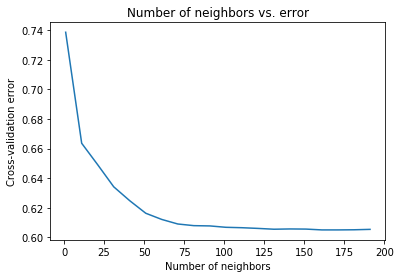

In [25]:
x_vals = list(range(1, 200, 10))
y_vals = []
for i in range(1,200,10):
    data_small = data.sample(frac=0.02,random_state=100)
    X = data_small.drop(['Age'], axis=1)
    y = data_small['Age']
    KNNClf = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(KNNClf, X, y, cv=5)
    y_vals.append(1-np.mean(scores))

plt.plot(x_vals, y_vals)
plt.xlabel('Number of neighbors')
plt.ylabel('Cross-validation error')
plt.title('Number of neighbors vs. error')
plt.show()

Based on this graph, we can see that the training error remains relatively constant above n_neighbors=75, so we will use this value. In splitting the data into training and test sets, we use the default test size of 0.25. Then we compute the test error for each category. 

In [26]:
columns = ['Gender', 'Age','City_Category','Stay_In_Current_City_Years','Marital_Status']

In [27]:
test_errors = []
for i in range(0,5):
    data_small = data.sample(frac=0.02,random_state=100)
    X = data_small.drop([columns[i]], axis=1)
    y = data_small[columns[i]]

    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)
    clf = KNeighborsClassifier(n_neighbors=75)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    test_error = 1 - metrics.accuracy_score(y_test, y_test_pred, normalize=True)
    test_errors.append(test_error)


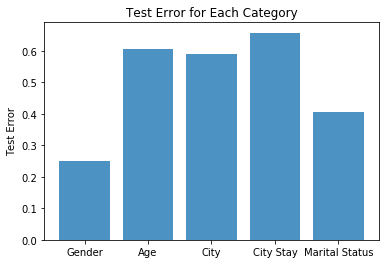

In [28]:
y_pos = np.arange(len(columns))
short_names = ['Gender', 'Age','City','City Stay','Marital Status']
plt.bar(y_pos, test_errors, align='center', alpha=0.8)
plt.xticks(y_pos, short_names)
plt.ylabel('Test Error')
plt.title('Test Error for Each Category')
 
plt.show()

As shown by this plot, the classifier had bad performance trying to predict most of the categories, performing the best when predicting gender. A possible reason for the bad performance is that there are no clear relationships in the data, so it is hard to predict what a category's value should be.

Another interesting thing we can do is predict the purchase amount given the rest of the dataset. Since purchase amount is not a categorical variable, we will use RMSE to evaluate the classifier.

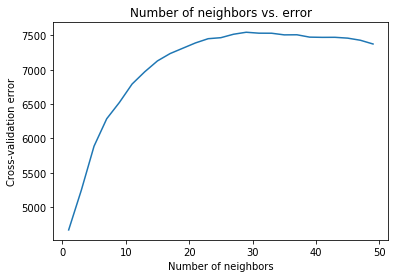

In [29]:
x_vals = list(range(1, 50, 2))
y_vals = []
for i in range(1,50,2):
    data_small = data.sample(frac=0.02,random_state=100)
    X = data_small.drop(['Purchase'], axis=1)
    y = data_small['Purchase']
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=100)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_test_pred))
    y_vals.append(rms)

plt.plot(x_vals, y_vals)
plt.xlabel('Number of neighbors')
plt.ylabel('Cross-validation error')
plt.title('Number of neighbors vs. error')
plt.show()

In [30]:
print(min(y_vals))

4666.358507031562


This classifier achieves the lowest RMSE (4666.359) when the n_neighbors parameter is 1. This may be because the purchase amount can be best predicted by the one observation closest to it, since some items are repeated in the data set and the price might be the same.

In [31]:
print(data['Purchase'].std())

4981.022132656483


The standard deviation of all the values in the Purchase category is 4981, so we see that on average, our classifier can predict the purchase within one standard deviation of the actual value.